# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

# 1D example

In [3]:
def f_1d_toy(x):
    if 2 <= x.item() <= 3:
        f = \
            -1600 * (x - 2.5) ** 5 - \
            2000 * (x - 2.5) ** 4 + \
            800 * (x - 2.5) ** 3 + \
            1020 * (x - 2.5) ** 2 

    elif 8.4 <= x.item() <= 8.40001:
        f = 1411.2 * (1 - 1e4 * (x - 8.4))

    elif 8.40001 <= x.item() <= 8.59999:

        f = x * 0

    elif 8.59999 <= x.item() <= 8.6:
        f = 1479.2 * (1e4 * (x - 8.6) + 1)

    else:
        f = 20 * x ** 2

    return f

In [4]:
xs = np.arange(-2, 10, 1e-3)
xs_torch = [torch.tensor([x]) for x in xs]
ys_torch = [f_1d_toy(x) for x in xs_torch]
ys = [y.item() for y in ys_torch]

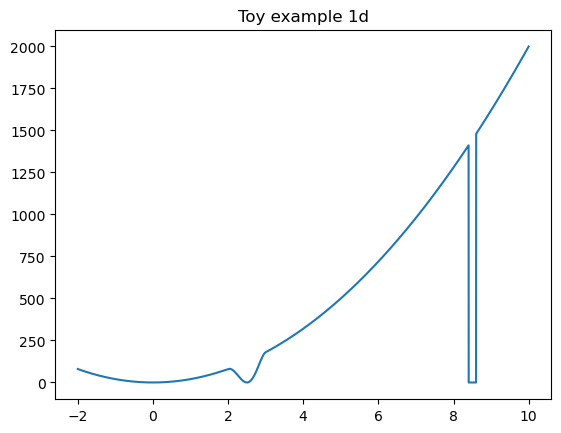

In [5]:
plt.plot(xs, ys)
plt.title('Toy example 1d')
plt.show()

In [6]:
def run_gd(func, lr, x_start_value, max_iter):
    x = torch.tensor(x_start_value, requires_grad=True)
    optimizer = optim.SGD([x], lr=lr)
    x_hist_torch = []

    n_iter = 0
    while len(x_hist_torch) == 0 or \
        torch.norm(x - x_hist_torch[-1]) > 1e-6 and \
        n_iter < max_iter:

        x_hist_torch.append(x.detach().clone())

        optimizer.zero_grad()
        func(x).backward()
        optimizer.step()
        n_iter += 1
        
    x_hist_torch.append(x.detach().clone())
    return x_hist_torch

In [7]:
def plot_1d_gd(lr, start_point, max_iter=1e3):

    xs = np.arange(-2, 10, 1e-3)
    xs_torch = [torch.tensor([x]) for x in xs]
    ys_torch = [f_1d_toy(x) for x in xs_torch]
    ys = [y.item() for y in ys_torch]
    plt.plot(xs, ys)

    x_hist_torch = run_gd(f_1d_toy, lr, [start_point], max_iter)
    y_hist_torch = [f_1d_toy(x) for x in x_hist_torch]
    x_hist = [x.item() for x in x_hist_torch]
    y_hist = [y.item() for y in y_hist_torch]

    plt.scatter(x_hist, y_hist, c=range(len(x_hist)))
    plt.title(f'Toy example 1d lr={lr}')
    plt.show()

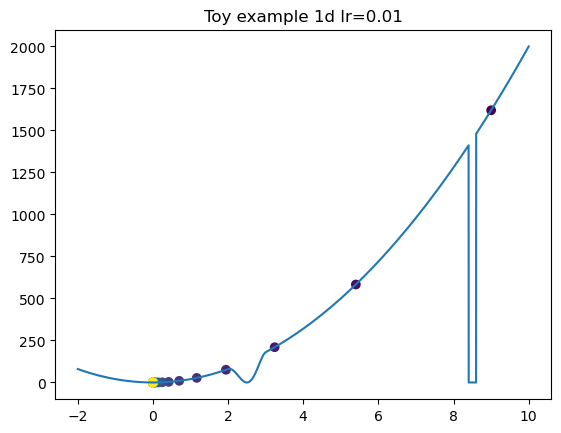

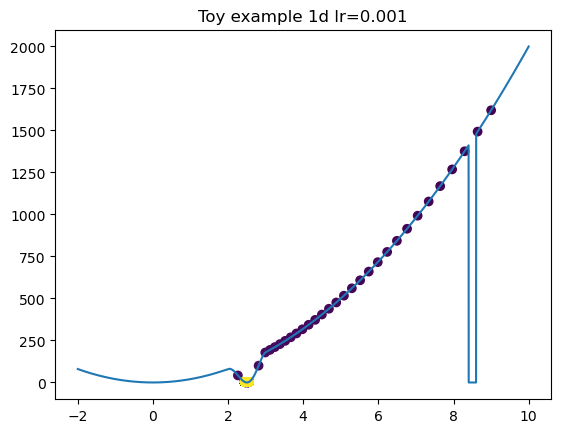

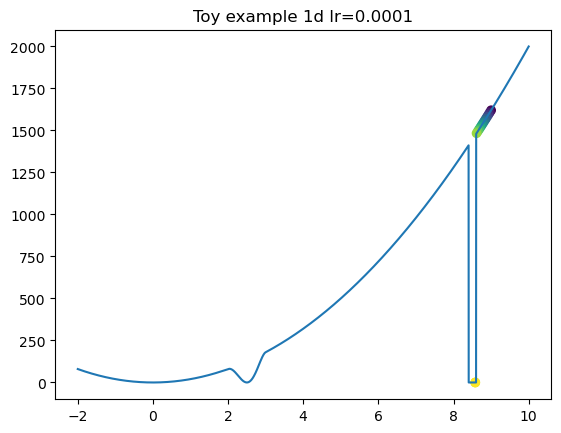

In [8]:
plot_1d_gd(1e-2, 9.)
plot_1d_gd(1e-3, 9.)
plot_1d_gd(1e-4, 9.)

In [9]:
import scipy.stats as ss
from itertools import product
from tqdm.notebook import tqdm
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import pandas as pd

In [10]:
lrs = np.linspace(1e-4, 1e-2, 15)
x_starts = np.linspace(8.5, 10, 20)
x_ends = np.zeros((len(lrs), len(x_starts)), dtype=float)

for (lr_i, lr), (x_start_i, x_start) in tqdm(
    product(enumerate(lrs), enumerate(x_starts))
):
    x_ends[lr_i, x_start_i] = run_gd(f_1d_toy, lr, [x_start], 1e3)[-1].item()

0it [00:00, ?it/s]

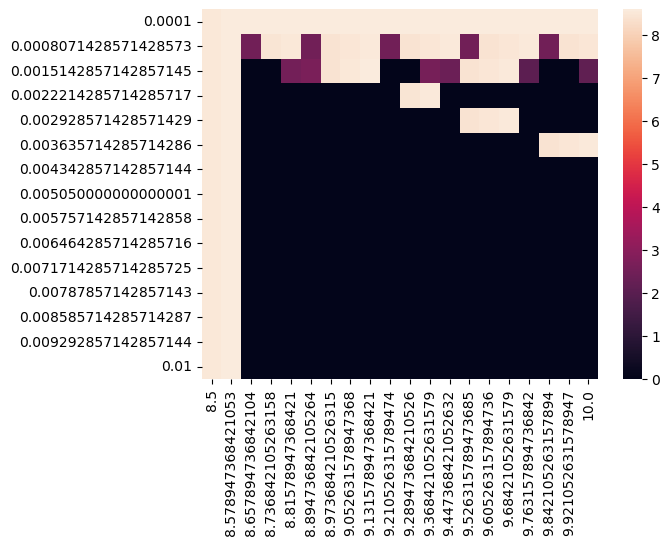

In [11]:
sns.heatmap(x_ends, yticklabels=lrs, xticklabels=x_starts)
plt.show()

# 2D example

In [17]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

In [12]:
import torch.nn.functional as F

In [13]:
def f_2d_toy(x, y):
    f_A = x ** 2 + y ** 2
    f_B = 200 * \
        F.relu(torch.abs(x) - 1) * \
        F.relu(torch.abs(y) - 1) * \
        F.relu(2 - torch.abs(x)) * \
        F.relu(2 - torch.abs(y))

    return f_A - f_B

In [14]:
x = torch.linspace(-3, 3, 40)
y = torch.linspace(-3, 3, 40)

grid_x, grid_y = torch.meshgrid(x, y, indexing='ij')

In [15]:
grid_z = f_2d_toy(grid_x, grid_y)

In [34]:
x_hist = run_gd(lambda x: f_2d_toy(x[0], x[1]), 0.01, torch.tensor([3., 2.5]), max_iter=1e4)
xs = np.array([x[0].item() for x in x_hist])
ys = np.array([x[1].item() for x in x_hist])
zs = f_2d_toy(torch.tensor(xs), torch.tensor(ys)).numpy()

/tmp/ipykernel_3159/166745264.py:2: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [38]:
fig = go.Figure(
    data=[
        go.Surface(
            x=grid_x.numpy(), 
            y=grid_y.numpy(), 
            z=grid_z.numpy(), 
            colorscale='Viridis', 
            showscale=False
        ),
        go.Scatter3d(
            x=xs, y=ys, z=zs,
        )
    ],
)

fig.show()

In [39]:
x_hist = run_gd(lambda x: f_2d_toy(x[0], x[1]), 0.05, torch.tensor([3., 2.5]), max_iter=1e4)
xs = np.array([x[0].item() for x in x_hist])
ys = np.array([x[1].item() for x in x_hist])
zs = f_2d_toy(torch.tensor(xs), torch.tensor(ys)).numpy()
fig = go.Figure(
    data=[
        go.Surface(
            x=grid_x.numpy(), 
            y=grid_y.numpy(), 
            z=grid_z.numpy(), 
            colorscale='Viridis', 
            showscale=False
        ),
        go.Scatter3d(
            x=xs, y=ys, z=zs,
        )
    ]
)
fig.show()

/tmp/ipykernel_3159/166745264.py:2: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



# NN example

In [19]:
torch.cuda.is_available()

True

In [20]:
device = torch.device("cuda")

# Data CIFAR10

In [21]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

batch_size = 4

trainset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=True,
    download=True, 
    transform=transform
)

trainloader = torch.utils.data.DataLoader(
    trainset, 
    batch_size=batch_size,
    shuffle=True, 
    num_workers=2
)

testset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=False,
    download=True, 
    transform=transform
)

testloader = torch.utils.data.DataLoader(
    testset, 
    batch_size=batch_size,
    shuffle=False, 
    num_workers=2
)

classes = (
    'plane', 'car', 'bird', 
    'cat', 'deer', 'dog', 
    'frog', 'horse', 'ship', 
    'truck'
)

Files already downloaded and verified
Files already downloaded and verified


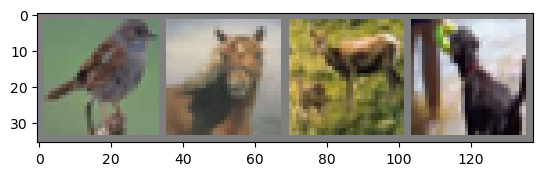

bird  horse deer  dog  


In [22]:
def imshow(img):
    img = img / 2 + 0.5 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# RESNET18

In [23]:
from torchvision.models import resnet18

# Train

In [24]:
model = resnet18().to(device)

In [25]:
import torch.optim as optim
from torch import nn

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [26]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.388
[1,  4000] loss: 2.049
[1,  6000] loss: 1.935
[1,  8000] loss: 1.865
[1, 10000] loss: 1.782
[1, 12000] loss: 1.725
[2,  2000] loss: 1.635
[2,  4000] loss: 1.569
[2,  6000] loss: 1.513
[2,  8000] loss: 1.475
[2, 10000] loss: 1.435
[2, 12000] loss: 1.405
Finished Training


In [27]:
model = resnet18().to(device)
import torch.optim as optim
from torch import nn

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.918
[1,  4000] loss: 2.346
[1,  6000] loss: 2.272
[1,  8000] loss: 2.267
[1, 10000] loss: 2.198
[1, 12000] loss: 2.146
[2,  2000] loss: 2.093
[2,  4000] loss: 2.060
[2,  6000] loss: 1.996
[2,  8000] loss: 1.971
[2, 10000] loss: 1.979
[2, 12000] loss: 1.932
Finished Training
